In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import time 
import numpy as np

from hemcee.kernels.hmc import hmc
from hemcee.kernels.hmc_side import hamiltonian_side_move
from hemcee.kernels.hmc_walk import hamiltonian_walk_move
from hemcee.kernels.hmc_walk_dual_averaging import hamiltonian_walk_move_dual_averaging

import corner

# Target Distribution

In [25]:
# Distribution
dim = 3

cond_number = 1000
eigenvals = 0.1 * np.linspace(1, cond_number, dim)
H = np.random.randn(dim, dim)
Q, _ = np.linalg.qr(H)
precision = Q @ np.diag(eigenvals) @ Q.T
precision = 0.5 * (precision + precision.T)


true_mean = jnp.zeros(dim)
precision_matrix = jnp.array(precision)

def potential(x):
    """Vectorized negative log density (potential energy)"""        
    # Vectorized operation for all samples
    centered = x - true_mean
    result = 0.5 * jnp.einsum('j,jk,k->', centered, precision_matrix, centered)
        
    return result

# Sampler setup
initial = jnp.zeros(dim)

n_samples = 10**5
burn_in = 10**4


# Sampler

In [ ]:
def timer(func, num_evals=5):
    times = []
    keys = jax.random.split(jax.random.PRNGKey(0), num_evals)
    for key in keys:
        start = time.perf_counter()
        try:
            _, _ = func(key)
        except: # For dual averaging, we need to return 3 values
            _, _, _ = func(key) 
        _.block_until_ready()
        elapsed = time.perf_counter() - start
        times.append(elapsed)
        print(f"Time taken: {elapsed:.3f} seconds")

    print('\nStatistics of time taken')
    print('Average: {:.3f} seconds'.format(np.mean(times)))  
    print('Standard deviation: {:.3f} seconds'.format(np.std(times)))

def statistics(func):
    try:
        samples, acceptance_rates = func(key)
    except: # For dual averaging, we need to return 3 values
        samples, acceptance_rates, _ = func(key)
    samples = samples.reshape(-1, dim)[-10000:]

def plot(func, key=jax.random.PRNGKey(0)):
    try:
        samples, acceptance_rates = func(key)
    except: # For dual averaging, we need to return 3 values
        samples, acceptance_rates, _ = func(key)
    samples = samples.reshape(-1, dim)[-10000:]
    corner.corner(np.array(samples))


Time taken: 0.405 seconds
Time taken: 0.548 seconds
Time taken: 0.589 seconds
Time taken: 0.458 seconds
Time taken: 0.396 seconds

Statistics of time taken
Average: 0.479 seconds
Standard deviation: 0.077 seconds


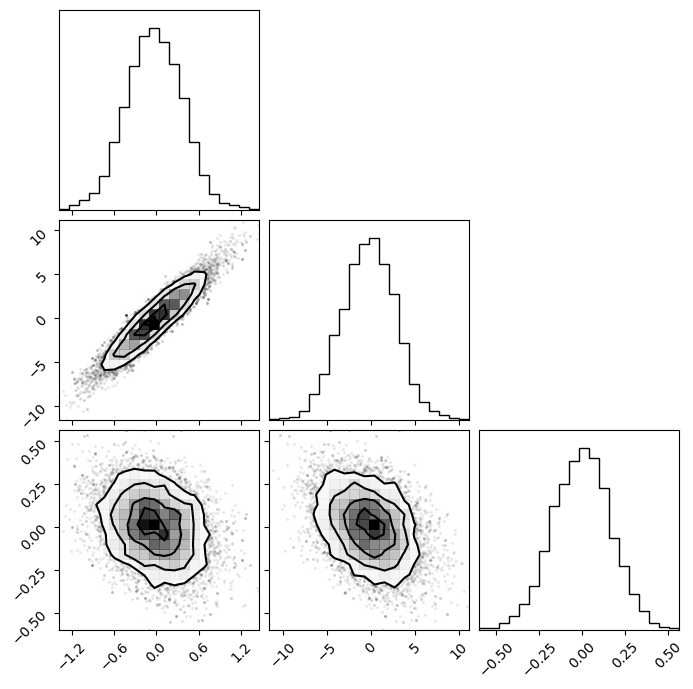

In [36]:
func = lambda key: hmc(potential, 
                       initial, 
                       n_samples,
                       n_chains=10,
                       step_size=0.1, 
                       L=10, 
                       n_thin=1,
                       key=key)
timer(func)
plot(func)

Time taken: 1.867 seconds
Time taken: 1.896 seconds
Time taken: 1.913 seconds
Time taken: 1.874 seconds
Time taken: 1.899 seconds

Statistics of time taken
Average: 1.890 seconds
Standard deviation: 0.017 seconds


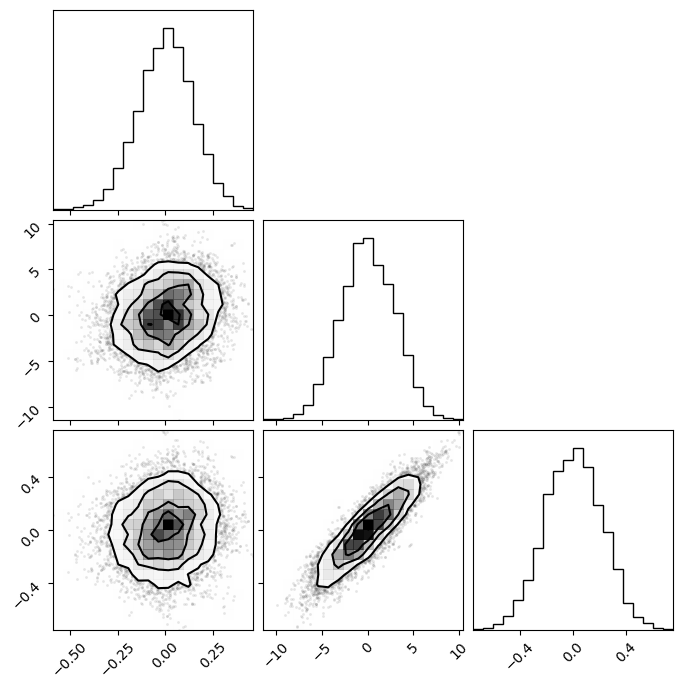

In [38]:
func = lambda key: hamiltonian_side_move(potential, 
                                         initial, 
                                         n_samples, 
                                         n_chains_per_group=5, 
                                         step_size=0.1, 
                                         L=10, 
                                         beta=1.0, 
                                         n_thin=1)
timer(func)
plot(func)

Time taken: 1.782 seconds
Time taken: 1.733 seconds
Time taken: 1.841 seconds
Time taken: 1.966 seconds
Time taken: 1.984 seconds

Statistics of time taken
Average: 1.861 seconds
Standard deviation: 0.099 seconds


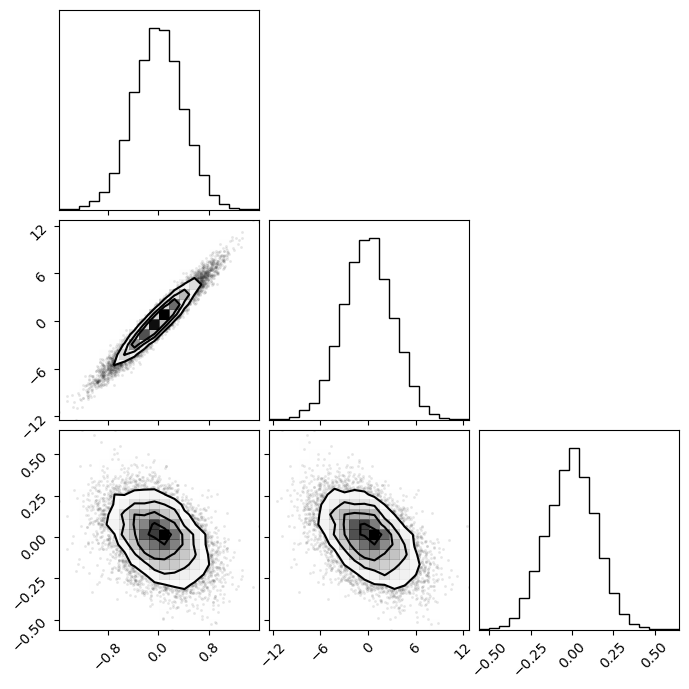

In [30]:
func = lambda key: hamiltonian_walk_move(potential, 
                                  initial, 
                                  n_samples, 
                                  n_chains_per_group=5, 
                                  step_size=0.1, 
                                  L=10, 
                                  beta=1.0,
                                  n_thin=1,
                                  key=key)
timer(func)
plot(func)

Time taken: 4.406 seconds
Time taken: 3.356 seconds
Time taken: 3.642 seconds
Time taken: 3.414 seconds
Time taken: 3.932 seconds

Statistics of time taken
Average: 3.750 seconds
Standard deviation: 0.386 seconds


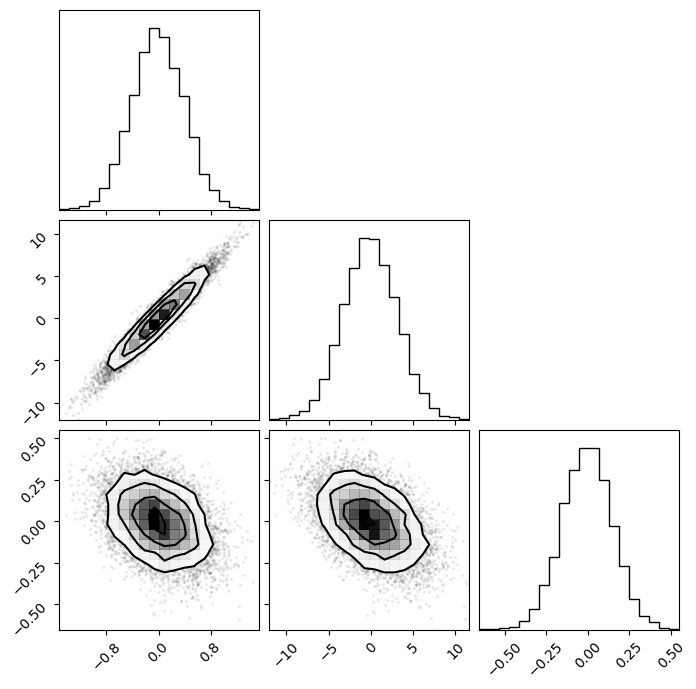

In [39]:
func = lambda key: hamiltonian_walk_move_dual_averaging(
                       potential, 
                       initial, 
                       n_samples,
                       epsilon=0.1, # Initial step size
                       L=10, 
                       beta=1.0,
                       key=key)
timer(func)
plot(func)